# Assignment Two:  Sentiment Classification


#### Import necessary packages
You may import more packages here.

In [42]:
# Import necessary packages
import re
from  os.path import join
import os
import numpy as np

from nltk.tokenize import word_tokenize

import torch


In [43]:
# Set the device to GPU if available
device = ('cuda' if torch.cuda.is_available() else 'cpu') 

Get the stopwords and lemmatiser from NLTK

In [44]:
#import nltk
#nltk.download('all') 

In [45]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Global paramaters
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [46]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [47]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

#### Preprocessing functions
- Preprocessing steps,tests and error analysis are described in the report

In [48]:
from nltk.corpus import wordnet

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [49]:
from nltk.tag import pos_tag


def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = pos_tag(word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatise the token
            lemmatized_sentence.append(lemma.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [50]:
# function that takes in a tweets and returns preprocessed tweet
def preprocess(tweet):
    # remove urls
    tweet = re.sub(r"((https?|ftp)://)?[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]+\.[a-z]{2,}[a-z0-9\-._~:/?#\[\]@!$&'()*+,;=%]*","",tweet)
    # remove usernames    
    tweet = re.sub('@[\w]+','',tweet)

    #remove hashtags
    tweet = re.sub(r'#\w+','',tweet)

    #replace all whitespace characters e.g convert \n into ' ' 
    tweet = re.sub(r"\s"," ",tweet)

    #remove non-alphanumeric charracters except spaces
    tweet = re.sub(r"[^A-Za-z0-9 ]","",tweet)

    # remove numbers
    tweet = re.sub(r"\b[0-9]\b","",tweet)

    # remove single characters
    tweet = re.sub(r'\b[A-Za-z]\b','',tweet)

    #stop word removal
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])

    #POS tagging and then lemmatize tweet
    tweet = lemmatize_sentence(tweet)
    return tweet



#### Define the local path where the semeval-tweets are located

In [51]:
# define the local path to the data_dir
data_dir = join(os.getcwd(), 'semeval-tweets')

In [52]:
print(data_dir)

c:\Users\burhan\OneDrive - University of Warwick\University\Comp Sci MSC\CS918 Natural Language Processing\Labs\Assignment 2\semeval-tweets


In [53]:
# define 0 to represent negative sentiment, 1 to represent neutral sentiment and 2 to represent positive sentiment
def sentiment_to_label(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'neutral':
        return 1
    elif sentiment == 'positive':
        return 2

def label_to_sentiment(label):
    if label == 0:
        return 'negative'
    elif label == 1:
        return 'neutral'
    elif label == 2:
        return 'positive'


In [54]:
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in ['twitter-training-data.txt','twitter-dev-data.txt'] + testsets:
    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []
    with open(join(data_dir, dataset), 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = sentiment_to_label(fields[1])

            #lowercase the tweet
            tweet = fields[2].lower()
            #preprocess the tweet
            tweet = preprocess(tweet)

            data[dataset].append((tweetid, gt, tweet))
            tweetids[dataset].append(tweetid)
            tweetgts[dataset].append(gt)
            tweets[dataset].append(tweet)


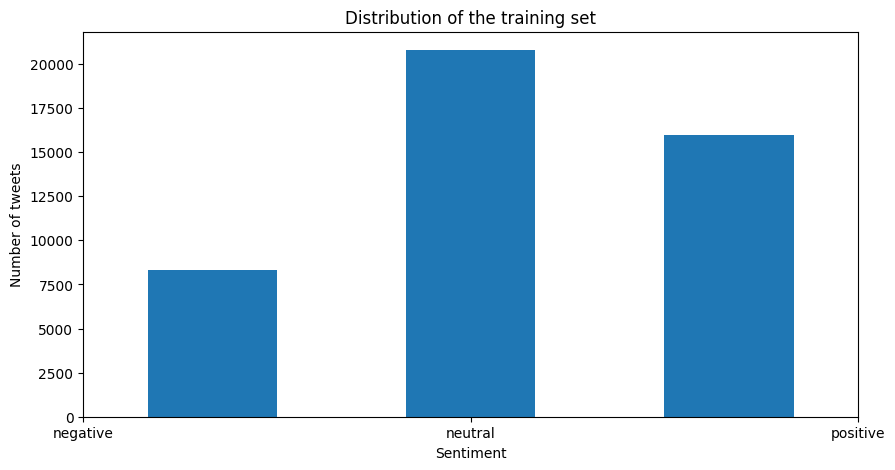

Distribution of the training set
negative: 8326 (18.46078800913505%)
neutral: 20789 (46.09432163366666%)
positive: 15986 (35.44489035719829%)


In [55]:
import matplotlib.pyplot as plt
# create a bar chart to show the distribution of the training set
plt.figure(figsize=(10, 5))
plt.hist(tweetgts['twitter-training-data.txt'], bins=3, align='mid', rwidth=0.5)
plt.xticks([0,1,2], ['negative', 'neutral', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.title('Distribution of the training set')
plt.show()

# print the % of tweets in each class in the training set
print('Distribution of the training set')


for label in [0, 1,2]:
    print(label_to_sentiment(label) + ': ' + str(tweetgts['twitter-training-data.txt'].count(label)) + ' (' + str(float(tweetgts['twitter-training-data.txt'].count(label)) / len(tweetgts['twitter-training-data.txt']) * 100) + '%)')

    twitter-training-data.txt
    Total tweets in datset: 45101
    Total negative tweets: 20789 
    Total neutral tweet: 15986
    Total Positive tweets: 0
    twitter-dev-data.txt
    Total tweets in datset: 2000
    Total negative tweets: 919 
    Total neutral tweet: 703
    Total Positive tweets: 0
    twitter-test1.txt
    Total tweets in datset: 3531
    Total negative tweets: 1504 
    Total neutral tweet: 1470
    Total Positive tweets: 0
    twitter-test2.txt
    Total tweets in datset: 1853
    Total negative tweets: 669 
    Total neutral tweet: 982
    Total Positive tweets: 0
    twitter-test3.txt
    Total tweets in datset: 2379
    Total negative tweets: 983 
    Total neutral tweet: 1033
    Total Positive tweets: 0

## Glove word embeddings

In [56]:
# dict of word and vector cpts
glove_map = {}
with open(join('glove.6B', 'glove.6B.100d.txt'), 'r', encoding='utf8') as fh:
    for line in fh:
        # split by spaces
        fields = line.split()
        #get the word
        word = fields[0]
        # get the vector
        vector = np.array(fields[1:], dtype=np.float32)
        # save it with the word as key
        glove_map[word] = vector

Get 5000 most frequent words

In [57]:
from collections import Counter
# max number of words
max_words = 5000
 
# tokenise the tweets using NLTK 
tokensised_tweets = [word_tokenize(tweet) for tweet in tweets['twitter-training-data.txt']]
# Convert each token to lowercase
tokensised_tweets = [[token.lower() for token in tweet] for tweet in tokensised_tweets]
word_freq = Counter([word for tweet in tokensised_tweets for word in tweet])
# get 4998 word counts, leave one for the unused index and one for unknown words
most_common = word_freq.most_common(max_words-2)
print(most_common)
top_5000_words = [word for word, freq in most_common]
print(top_5000_words)

[('tomorrow', 5768), ('may', 5493), ('go', 4892), ('get', 3851), ('day', 3532), ('see', 2951), ('im', 2824), ('like', 2517), ('night', 2510), ('time', 2300), ('1st', 2138), ('sunday', 2134), ('friday', 2067), ('make', 2032), ('come', 1956), ('watch', 1954), ('one', 1933), ('say', 1932), ('new', 1700), ('want', 1680), ('game', 1638), ('think', 1565), ('know', 1554), ('good', 1547), ('saturday', 1537), ('2nd', 1515), ('monday', 1493), ('dont', 1422), ('amp', 1402), ('today', 1401), ('3rd', 1256), ('love', 1242), ('tonight', 1224), ('take', 1215), ('well', 1206), ('play', 1184), ('look', 1177), ('us', 1175), ('last', 1147), ('back', 1145), ('still', 1134), ('show', 1095), ('cant', 1078), ('thursday', 1035), ('na', 1035), ('start', 1004), ('david', 998), ('big', 988), ('win', 979), ('first', 979), ('would', 977), ('need', 958), ('best', 954), ('trump', 904), ('great', 885), ('sun', 877), ('next', 873), ('wait', 864), ('right', 835), ('work', 833), ('people', 828), ('happy', 804), ('year', 

In [58]:
# create word-to-index dictionary
word_to_index = {}
word_to_index['<PAD>'] = 0  # add <PAD> token at index 0
word_to_index['<UNK>'] = 1  # add <UNK> token at index 0
for i, word in enumerate(top_5000_words):
    word_to_index[word] = i + 2  # add 2 to index since we added <PAD> and <UNK> tokens

# create index-to-word dictionary
index_to_word = {v: k for k, v in word_to_index.items()}

Create the embedding matrix

In [59]:
#embedding dimensino
embedding_dim = 100
# max words
max_words = 5000
# Find the longest tweet
maxlen = max([len(tweet.split()) for tweet in tweets['twitter-training-data.txt']])
print(maxlen)

# create the embedding matrix

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_to_index.items():
    if i < max_words:
        embedding_vector = glove_map.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


30


In [60]:
# pad the sequences to the same length after the last word using numpy
def pad_sequences(X, max_len):
    return np.array([np.pad(x, pad_width=[0, max_len - len(x)], mode='constant') for x in X])

In [61]:
# convert the tweets to sequences of indices
def convert_tweets_to_indices(tweets, word_to_index, max_len):
    X =np.zeros((len(tweets),max_len),dtype=int)
    for i,tweet in enumerate(tweets):
        # convert the tweet to a sequence of indices
        indices = [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in tweet.split()]
        # pad the sequence to the same length after the last word
        indices_padded = pad_sequences([indices], max_len)
        # add the indices to the matrix
        X[i] = indices_padded        
    return X

#### Build sentiment classifiers


In [62]:
# import the models that will be tested
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [63]:
# Class for each feature representation
class FeatureRepresentation:
    def __init__(self, name, vectorizer):
        self.name = name
        self.vectorizer = vectorizer

    def fit_transform(self, X):
        return self.vectorizer.fit_transform(X)
    
    def transform(self, X):
        return self.vectorizer.transform(X)


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the feature representations
bow = FeatureRepresentation('bow', CountVectorizer())
tfidf = FeatureRepresentation('tf-idf', TfidfVectorizer())
ngram = FeatureRepresentation('ngram', CountVectorizer(ngram_range=(1,2)))


In [65]:
def feature_vectoriser(features):
    if features == 'bow':
        return bow.fit_transform(tweets['twitter-training-data.txt'])
    elif features == 'tfidf':
        return tfidf.fit_transform(tweets['twitter-training-data.txt'])
    elif features == 'ngram':
        return ngram.fit_transform(tweets['twitter-training-data.txt'])

In [66]:
#import dataloader
from torch.utils.data import TensorDataset, DataLoader
#LSTM model
# Define the number of epochs
num_epochs = 20
# Define the batch size
batch_size = 32

#learning rate
lr = 0.001

# training and validation data 
x_train_inds = (convert_tweets_to_indices(tweets['twitter-training-data.txt'], word_to_index, maxlen))
x_valid_inds = (convert_tweets_to_indices(tweets['twitter-dev-data.txt'], word_to_index, maxlen))

# create data loaders
# convert the sequences of indices to a tensor
x_train_tensor =( torch.from_numpy(x_train_inds)).to(device)
x_valid_tensor = (torch.from_numpy(x_valid_inds)).to(device)


# convert the labels to a tensor of longs
y_train_tensor =( torch.from_numpy(np.array(tweetgts['twitter-training-data.txt'])).to(device)).long()


y_valid_tensor = (torch.from_numpy(np.array(tweetgts['twitter-dev-data.txt'])).to(device)).long()

# create the training dataloaders
train_loader = DataLoader(TensorDataset(x_train_tensor,y_train_tensor),batch_size=batch_size,shuffle=True,drop_last=True)
valid_loader = DataLoader(TensorDataset(x_valid_tensor,y_valid_tensor),batch_size=batch_size,shuffle=True,drop_last=True)

In [67]:
# Get confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def get_metrics(Y_actual,Y_preds,target_names=['negative','Neutral','Positive']):


    # Overall Test Accuracy
    print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))

    # Report for each class
    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=target_names))

    # Confusion Matrix
    #print("\nConfusion Matrix : ")
    #print(confusion_matrix(Y_actual, Y_preds))

In [68]:
from sklearn.metrics import accuracy_score
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    # -- Disable the gradient --
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss  = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)
        epoch_loss = torch.tensor(losses).mean()
        print("Valid Loss : {:.3f}".format(epoch_loss))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())))
        return epoch_loss.cpu().detach().numpy()

In [69]:
import torch.nn as nn
# Define the LSTM model
# define the model
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_dim,num_layers,dropout,bidirectional):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True,bidirectional=bidirection)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    # shape of inputs: (batch_size, seq_len) (32,30)
    def forward(self, inputs):

        # shape of embeds: (batch_size, seq_len, embedding_dim) (32,30,100)
        embeds = self.embedding(inputs)
        embeds = self.dropout(embeds)
        # shape of lstm_out: (seq_len, batch_size, hidden_dim) (30,32,128)
        output, (hidden, carry) = self.lstm(embeds)

        output = self.lstm(embeds),(hidden, carry)
        #output = self.softmax(output)
        output = self.fc(hidden[-1])
        return output
    
    
# define the model hyperparameters
vocab_size = len(word_to_index)
embedding_dim = 100
hidden_dim = 110
output_dim = 3
num_layers = 1
bidirection = True
dropout = 0.5

# instantiate the model

LSTMModel = LSTMModel(embedding_dim, hidden_dim, vocab_size, output_dim,num_layers,dropout,bidirection)
LSTMModel.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
LSTMModel.embedding.weight.requires_grad = False
LSTMModel.to(device)

# define the optimizer
optimizer = torch.optim.Adam(LSTMModel.parameters(), lr=lr)

# define the loss function
criterion = nn.CrossEntropyLoss()


print(LSTMModel)

LSTMModel(
  (embedding): Embedding(5000, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(100, 110, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=110, out_features=3, bias=True)
)


In [70]:
def plot_loss(losses_per_epoch, valid_losses_per_epoch):
    plt.plot(np.arange(1,len(losses_per_epoch)+1),losses_per_epoch,'bo-')
    plt.plot(np.arange(1,len(valid_losses_per_epoch)+1),valid_losses_per_epoch,'ro-')
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show   

In [71]:
from tqdm import tqdm
# Training Loop
def TrainingLoop(model, loss_fn, optimizer, train_loader, val_loader, epochs):
    losses_per_epoch = []
    valid_losses_per_epoch = []
    epochs_no_improve = 0
    for i in range(1, epochs+1):
        model = model.train()
        losses = []
        # Cycle over the training examples (using minibatches)
        # X are the examples, Y are the associated labels
        for X, Y in tqdm(train_loader):
            # Make the prediction
            Y_preds = model(X)

            # Compute the loss
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            # Reset the gradient
            optimizer.zero_grad()
            
            # Compute the gradient
            loss.backward()
            
            # Update the weights
            optimizer.step()

        train_loss = torch.tensor(losses).mean()
        losses_per_epoch.append(train_loss.cpu().detach().numpy())
        print("Train Loss : {:.3f}".format(train_loss))
        valid_losses= CalcValLossAndAccuracy(model, loss_fn, val_loader)
        if (i!=1 and valid_losses > min(valid_losses_per_epoch)):
            epochs_no_improve += 1
            if epochs_no_improve == 5:
                print('Early stopping!')
                return losses_per_epoch, valid_losses_per_epoch
                
        valid_losses_per_epoch.append(valid_losses)
    return losses_per_epoch, valid_losses_per_epoch

In [72]:
def TestLoop(model,testset,):
    
    # get the maximum length of the tweets in the testset
    max_len  = max([len(tweet) for tweet in tweets[testset]])
    # convert the tweets to indices
    x_test = torch.from_numpy(convert_tweets_to_indices(tweets[testset], word_to_index, max_len)).to(device)
    test_loader = DataLoader(TensorDataset(x_test),batch_size=batch_size,shuffle=False,drop_last=False)
    test_predicted_labels = []
    model = model.eval()
    with torch.no_grad():
      for x in tqdm(test_loader):
          x = x[0].to(device)
          y_pred = model(x)
          # get the arg max for each row
          y_pred = y_pred.argmax(1).cpu().numpy()
          test_predicted_labels.extend(y_pred)
    #return the predicted labels
    return test_predicted_labels




#### Train all classifiers

In [73]:
# define the labels
y_train = tweetgts['twitter-training-data.txt']
# classifiers to test
for classifier in ['svm','nb','logistic-reg','LSTM']:
    model = None
    # feature representations to test
    for features in ['bow', 'tfidf', 'ngram']:                     

        if classifier == 'svm':
            model= LinearSVC(C=0.1, penalty='l2', max_iter=1000, dual=False)
            x_train = feature_vectoriser(features)
          
 
        elif classifier == 'nb':
            model = MultinomialNB(alpha=0.1, fit_prior=True)
            x_train = feature_vectoriser(features)
           
        
        elif classifier == 'logistic-reg':
            model = LogisticRegression(C=0.1, penalty='l2', max_iter=1000)
            x_train = feature_vectoriser(features)
            

        elif classifier == 'LSTM':
            if features == 'bow':
                losses_per_epoch, valid_losses_per_epoch = TrainingLoop(LSTMModel.to(device), criterion, optimizer, train_loader, valid_loader, num_epochs)        
                #plot_loss(losses_per_epoch, valid_losses_per_epoch)
                            
        else:
            print('Unknown classifier name' + classifier)
            continue
        
        print('Training ' + classifier)

        # Train the classifier
        if classifier != 'LSTM':
            model.fit(x_train, y_train)
            

        # Prediction performance of the classifiers
        for testset in testsets:
            # dictionary of ids and predictions
            id_preds = {}
            y_pred = []

            if classifier == 'LSTM':
                y_pred = TestLoop(LSTMModel,testset)
                y_pred = [label_to_sentiment(label) for label in y_pred]
                features = 'GloVe Word Embeddings'
            
            else:
                if features == 'bow':
                    # convert the tweets into a bag-of-word representation
                    x_test = bow.transform(tweets[testset])
                elif features == 'tfidf':
                    # use the tf-idf representation of the tweets
                    x_test = tfidf.transform(tweets[testset])
                elif features == 'ngram':
                    # use the n-gram representation of the tweets
                    x_test = ngram.transform(tweets[testset])
                # predict the sentiment of the tweets and convert the labels to sentiment
                y_pred = [label_to_sentiment(label) for label in model.predict(x_test)]
            
            # get_metrics(y_pred, tweetgts[testset])
            id_preds = {tweet_id: y_pred[i] for i, tweet_id in enumerate(tweetids[testset])}

            # evaluate the performance of the classifier
            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)

Training svm
semeval-tweets\twitter-test1.txt (bow-svm): 0.551
semeval-tweets\twitter-test2.txt (bow-svm): 0.573
semeval-tweets\twitter-test3.txt (bow-svm): 0.532
Training svm
semeval-tweets\twitter-test1.txt (tfidf-svm): 0.512
semeval-tweets\twitter-test2.txt (tfidf-svm): 0.547
semeval-tweets\twitter-test3.txt (tfidf-svm): 0.503
Training svm
semeval-tweets\twitter-test1.txt (ngram-svm): 0.559
semeval-tweets\twitter-test2.txt (ngram-svm): 0.613
semeval-tweets\twitter-test3.txt (ngram-svm): 0.535
Training nb
semeval-tweets\twitter-test1.txt (bow-nb): 0.500
semeval-tweets\twitter-test2.txt (bow-nb): 0.500
semeval-tweets\twitter-test3.txt (bow-nb): 0.488
Training nb
semeval-tweets\twitter-test1.txt (tfidf-nb): 0.413
semeval-tweets\twitter-test2.txt (tfidf-nb): 0.428
semeval-tweets\twitter-test3.txt (tfidf-nb): 0.415
Training nb
semeval-tweets\twitter-test1.txt (ngram-nb): 0.482
semeval-tweets\twitter-test2.txt (ngram-nb): 0.517
semeval-tweets\twitter-test3.txt (ngram-nb): 0.495
Training l

100%|██████████| 1409/1409 [00:05<00:00, 265.40it/s]


Train Loss : 0.909
Valid Loss : 0.867
Valid Acc  : 0.580


100%|██████████| 1409/1409 [00:05<00:00, 277.33it/s]


Train Loss : 0.860
Valid Loss : 0.857
Valid Acc  : 0.591


100%|██████████| 1409/1409 [00:05<00:00, 277.74it/s]


Train Loss : 0.840
Valid Loss : 0.842
Valid Acc  : 0.609


100%|██████████| 1409/1409 [00:05<00:00, 268.23it/s]


Train Loss : 0.825
Valid Loss : 0.827
Valid Acc  : 0.618


100%|██████████| 1409/1409 [00:05<00:00, 276.76it/s]


Train Loss : 0.812
Valid Loss : 0.827
Valid Acc  : 0.618


100%|██████████| 1409/1409 [00:05<00:00, 277.09it/s]


Train Loss : 0.804
Valid Loss : 0.827
Valid Acc  : 0.614


100%|██████████| 1409/1409 [00:05<00:00, 268.69it/s]


Train Loss : 0.794
Valid Loss : 0.816
Valid Acc  : 0.616


100%|██████████| 1409/1409 [00:05<00:00, 276.65it/s]


Train Loss : 0.789
Valid Loss : 0.814
Valid Acc  : 0.633


100%|██████████| 1409/1409 [00:05<00:00, 276.47it/s]


Train Loss : 0.777
Valid Loss : 0.810
Valid Acc  : 0.616


100%|██████████| 1409/1409 [00:05<00:00, 268.23it/s]


Train Loss : 0.772
Valid Loss : 0.827
Valid Acc  : 0.623


100%|██████████| 1409/1409 [00:05<00:00, 273.11it/s]


Train Loss : 0.767
Valid Loss : 0.831
Valid Acc  : 0.626


100%|██████████| 1409/1409 [00:05<00:00, 277.47it/s]


Train Loss : 0.762
Valid Loss : 0.836
Valid Acc  : 0.613


100%|██████████| 1409/1409 [00:05<00:00, 270.18it/s]


Train Loss : 0.759
Valid Loss : 0.813
Valid Acc  : 0.621


100%|██████████| 1409/1409 [00:05<00:00, 275.52it/s]


Train Loss : 0.750
Valid Loss : 0.805
Valid Acc  : 0.634


100%|██████████| 1409/1409 [00:05<00:00, 276.98it/s]


Train Loss : 0.748
Valid Loss : 0.823
Valid Acc  : 0.620
Early stopping!
Training LSTM


100%|██████████| 111/111 [00:00<00:00, 264.92it/s]


semeval-tweets\twitter-test1.txt (GloVe Word Embeddings-LSTM): 0.535


100%|██████████| 58/58 [00:00<00:00, 272.33it/s]


semeval-tweets\twitter-test2.txt (GloVe Word Embeddings-LSTM): 0.554


100%|██████████| 75/75 [00:00<00:00, 251.67it/s]


semeval-tweets\twitter-test3.txt (GloVe Word Embeddings-LSTM): 0.534
Training LSTM


100%|██████████| 111/111 [00:00<00:00, 257.54it/s]


semeval-tweets\twitter-test1.txt (GloVe Word Embeddings-LSTM): 0.535


100%|██████████| 58/58 [00:00<00:00, 261.24it/s]


semeval-tweets\twitter-test2.txt (GloVe Word Embeddings-LSTM): 0.554


100%|██████████| 75/75 [00:00<00:00, 244.30it/s]


semeval-tweets\twitter-test3.txt (GloVe Word Embeddings-LSTM): 0.534
Training LSTM


100%|██████████| 111/111 [00:00<00:00, 249.44it/s]


semeval-tweets\twitter-test1.txt (GloVe Word Embeddings-LSTM): 0.535


100%|██████████| 58/58 [00:00<00:00, 262.45it/s]


semeval-tweets\twitter-test2.txt (GloVe Word Embeddings-LSTM): 0.554


100%|██████████| 75/75 [00:00<00:00, 250.00it/s]

semeval-tweets\twitter-test3.txt (GloVe Word Embeddings-LSTM): 0.534
